In [5]:
from trajectree.fock_optics.utils import create_vacuum_state
from trajectree.fock_optics.devices import global_phase
from trajectree.quant_info.noise_models import amplitude_damping
from trajectree.quant_info.circuit import Circuit
from trajectree.trajectory import quantum_channel, trajectory_evaluator
import numpy as np
from scipy import sparse as sp
from matplotlib import pyplot as plt
import cirq
import qsimcirq
import time

from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.noise import amplitude_damping_error
from qiskit import transpile, QuantumCircuit
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.primitives import SamplerResult

from mqt.bench import BenchmarkLevel, get_benchmark

Benchmarking circuits

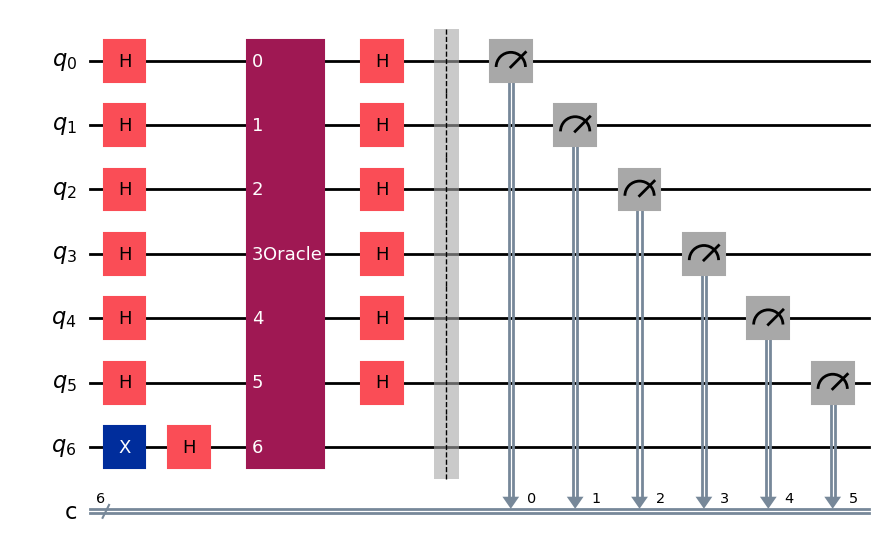

In [6]:
num_qubits = 7
qc = get_benchmark("dj", BenchmarkLevel.ALG, num_qubits)
qc.draw(output="mpl")

/tmp/ipykernel_2895708/127223005.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in transpiled_qc_custom.data:


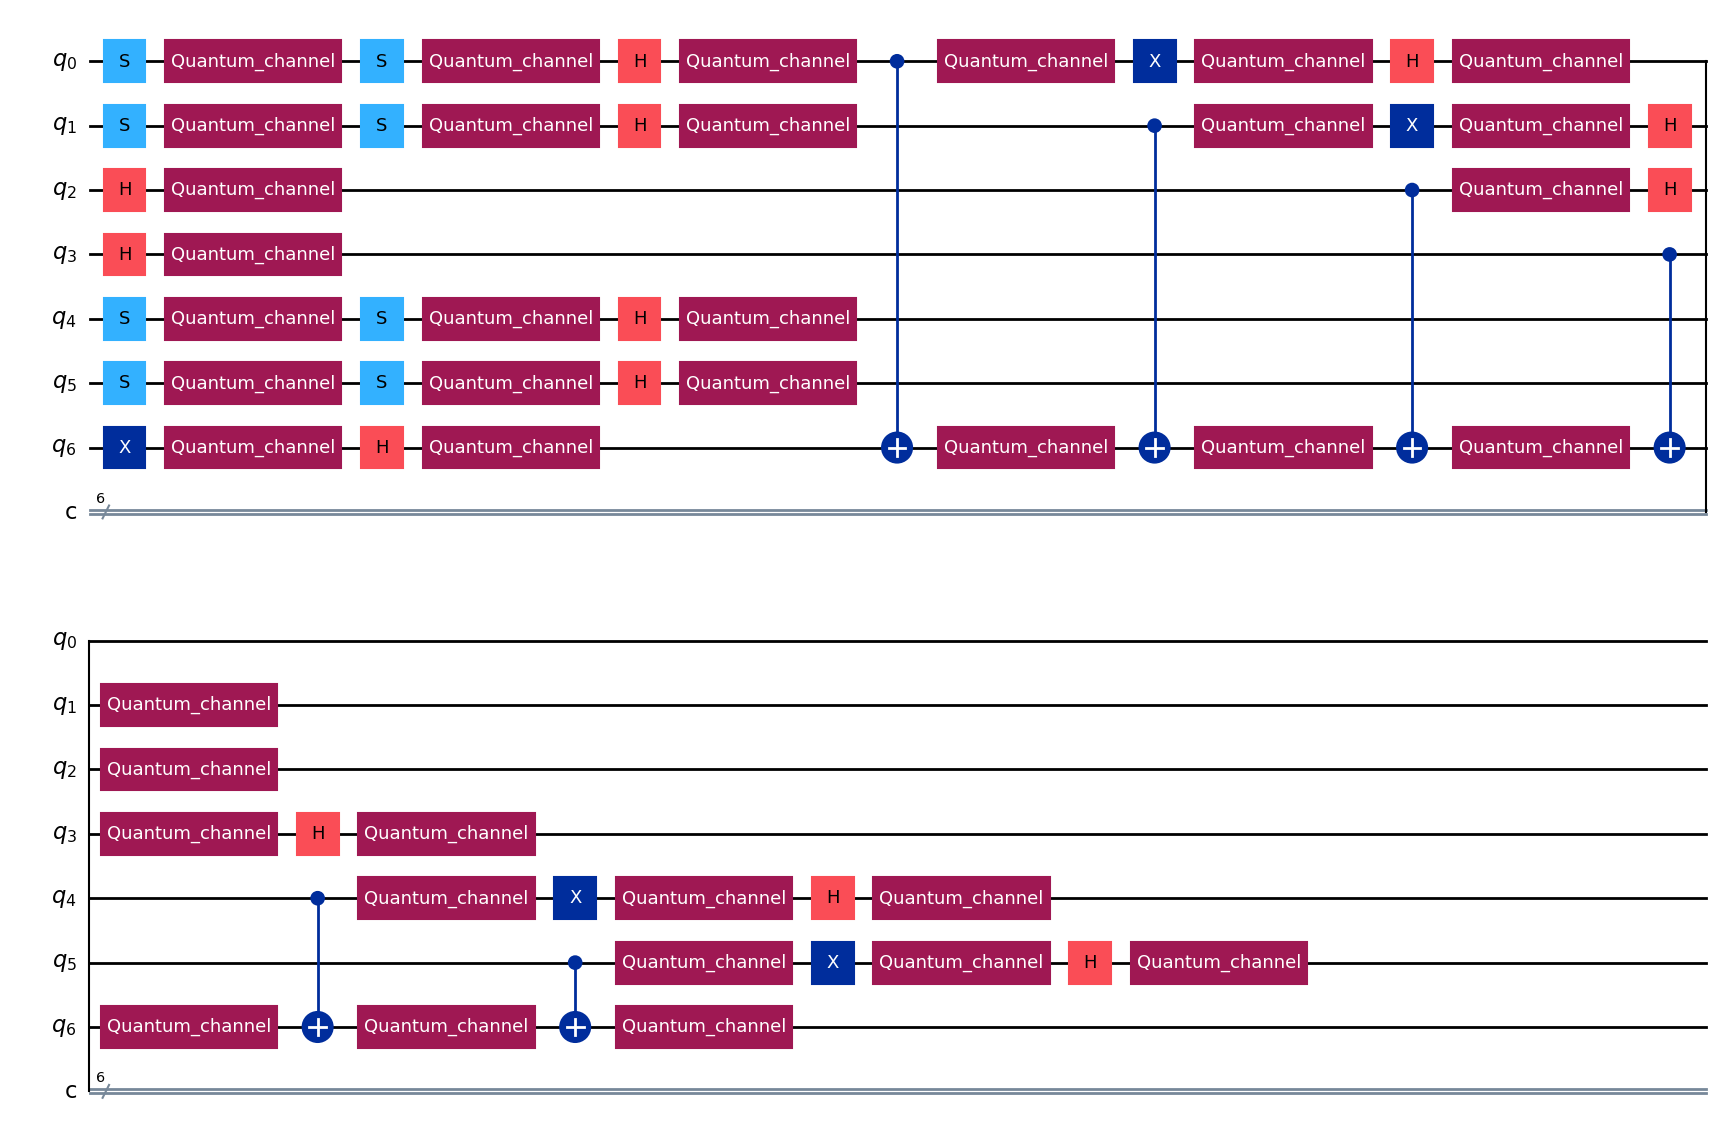

In [16]:
# print(dumps(qc))
target_basis = ['h', 's', 'x', 'cx', 't']
transpiled_qc_custom = transpile(qc, basis_gates=target_basis, optimization_level=1)

noise_probability = 0.5
noise_channel = amplitude_damping_error(noise_probability)

noisy_transpiled_qc_custom = QuantumCircuit(transpiled_qc_custom.num_qubits, transpiled_qc_custom.num_clbits)
for instr, qargs, cargs in transpiled_qc_custom.data:
    if instr.name not in {"measure", "barrier"}:
        noisy_transpiled_qc_custom.append(instr, qargs, cargs)
        for q in qargs:
            noisy_transpiled_qc_custom.append(noise_channel, [q])        

transpiled_qc_custom = noisy_transpiled_qc_custom

transpiled_qc_custom.draw(output="mpl")

# for i in transpiled_qc_custom:
#     print(i.operation.name)
#     print([qubit._index for qubit in i.qubits])
# transpiled_qc_custom.draw(output="mpl")

In [26]:
observable = SparsePauliOp("Z" * num_qubits)

# Use the Sampler primitive for latest API
backend = AerSampler()
estimator = Estimator()
estimator.options.run_options = {"shots":1000}
estimator.options.backend_options = dict(noise_model=noise_channel)
# print(estimator.options)

# Run the sampler
job = estimator.run([(transpiled_qc_custom, observable)])
result = job.result()

pub_result = result[0]
print(result)
print(pub_result.data.stds)
print(pub_result.data.evs)

# # Extract measurement counts directly from the result
# counts_dict = result.quasi_dists[0].binary_probabilities()
# # Convert probabilities to counts
# counts = {state: int(prob * 1000) for state, prob in counts_dict.items()}

# print("Measurement counts from noisy circuit:")
# print(counts)
# print(f"\nTotal shots: {sum(counts.values())}")

# # Plot the distribution
# from matplotlib import pyplot as plt
# plt.figure(figsize=(12, 6))
# plt.bar(range(len(counts)), list(counts.values()))
# plt.xlabel('Measurement outcome')
# plt.ylabel('Counts')
# plt.title('Measurement Distribution from Noisy Circuit')
# plt.xticks(range(len(counts)), list(counts.keys()), rotation=90)
# plt.tight_layout()
# plt.show()


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata': {'time_taken_parameter_binding': 3.5528e-05, 'time_taken_execute': 0.026515871, 'omp_enabled': True, 'max_gpu_memory_mb': 0, 'max_memory_mb': 257534, 'parallel_experiments': 1}})], metadata={'version': 2})
0.0
0.023318433132059637


In [4]:
# Create a copy and add measurements
circuit_to_measure = transpiled_qc_custom.copy()

# Use the Sampler primitive for latest API
sampler = AerSampler()

# Run the sampler
job = sampler.run(circuit_to_measure, shots=1000)
result = job.result()

# Extract measurement counts directly from the result
counts_dict = result.quasi_dists[0].binary_probabilities()
# Convert probabilities to counts
counts = {state: int(prob * 1000) for state, prob in counts_dict.items()}

print("Measurement counts from noisy circuit:")
print(counts)
print(f"\nTotal shots: {sum(counts.values())}")

# Plot the distribution
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(range(len(counts)), list(counts.values()))
plt.xlabel('Measurement outcome')
plt.ylabel('Counts')
plt.title('Measurement Distribution from Noisy Circuit')
plt.xticks(range(len(counts)), list(counts.keys()), rotation=90)
plt.tight_layout()
plt.show()


ValueError: The 0-th circuit does not have Measure instruction. Without measurements, the circuit cannot be sampled from.

In [7]:
import cirq

# Create Cirq qubits
num_qubits_cirq = transpiled_qc_custom.num_qubits
cirq_qubits = cirq.LineQubit.range(num_qubits_cirq)

# Map Qiskit gates to Cirq gates
gate_map = {
    'h': lambda q: cirq.H(q),
    's': lambda q: cirq.S(q),
    't': lambda q: cirq.T(q),
    'x': lambda q: cirq.X(q),
    'cx': lambda q0, q1: cirq.CNOT(q0, q1),
    'measure': lambda q: None,  # We'll handle measurements separately
    'barrier': lambda *args: None,
}

# Build the Cirq circuit
cirq_circuit = cirq.Circuit()

for circuit_instr in transpiled_qc_custom.data:
    instr = circuit_instr.operation
    qargs = circuit_instr.qubits
    cargs = circuit_instr.clbits
    gate_name = instr.name
    
    if gate_name == 'quantum_channel':
        # This is the amplitude damping error
        # Extract the damping parameter from the Kraus operators
        for qarg in qargs:
            cirq_qubit = cirq_qubits[qarg._index]
            cirq_circuit.append(cirq.amplitude_damp(gamma=noise_probability)(cirq_qubit))
    
    elif gate_name in gate_map and gate_name not in ['measure', 'barrier']:
        cirq_qubit_args = [cirq_qubits[q._index] for q in qargs]
        gate = gate_map[gate_name](*cirq_qubit_args)
        if gate is not None:
            cirq_circuit.append(gate)

# Add measurements at the end
cirq_circuit.append(cirq.measure(*cirq_qubits, key='result'))

print(f"Converted Cirq circuit with {len(cirq_circuit)} moments")
print(f"Number of operations: {len(list(cirq_circuit.all_operations()))}")
print("\nFirst 50 operations:")
for i, op in enumerate(cirq_circuit.all_operations()):
    if i >= 50:
        break
    print(f"{i}: {op}")

# Draw a portion of the circuit
print("\nCircuit diagram (first 20 moments):")
print(cirq.Circuit(list(cirq_circuit[:20])))


Converted Cirq circuit with 23 moments
Number of operations: 71

First 50 operations:
0: S(q(0))
1: S(q(1))
2: H(q(2))
3: H(q(3))
4: S(q(4))
5: S(q(5))
6: X(q(6))
7: amplitude_damp(gamma=0.5)(q(0))
8: amplitude_damp(gamma=0.5)(q(1))
9: amplitude_damp(gamma=0.5)(q(2))
10: amplitude_damp(gamma=0.5)(q(3))
11: amplitude_damp(gamma=0.5)(q(4))
12: amplitude_damp(gamma=0.5)(q(5))
13: amplitude_damp(gamma=0.5)(q(6))
14: S(q(0))
15: S(q(1))
16: S(q(4))
17: S(q(5))
18: H(q(6))
19: amplitude_damp(gamma=0.5)(q(0))
20: amplitude_damp(gamma=0.5)(q(1))
21: amplitude_damp(gamma=0.5)(q(4))
22: amplitude_damp(gamma=0.5)(q(5))
23: amplitude_damp(gamma=0.5)(q(6))
24: H(q(0))
25: H(q(1))
26: H(q(4))
27: H(q(5))
28: amplitude_damp(gamma=0.5)(q(0))
29: amplitude_damp(gamma=0.5)(q(1))
30: amplitude_damp(gamma=0.5)(q(4))
31: amplitude_damp(gamma=0.5)(q(5))
32: CNOT(q(0), q(6))
33: amplitude_damp(gamma=0.5)(q(0))
34: amplitude_damp(gamma=0.5)(q(6))
35: X(q(0))
36: CNOT(q(1), q(6))
37: amplitude_damp(gamma=0.5)(

Running Cirq circuit with amplitude damping noise...

Generated 1000 measurement samples

Unique measurement outcomes: 104

Top 10 measurement outcomes:
  0000000: 176
  1000000: 58
  0010000: 51
  0100000: 48
  0001000: 41
  0000010: 41
  0000100: 40
  0000001: 35
  1000010: 25
  1000100: 21


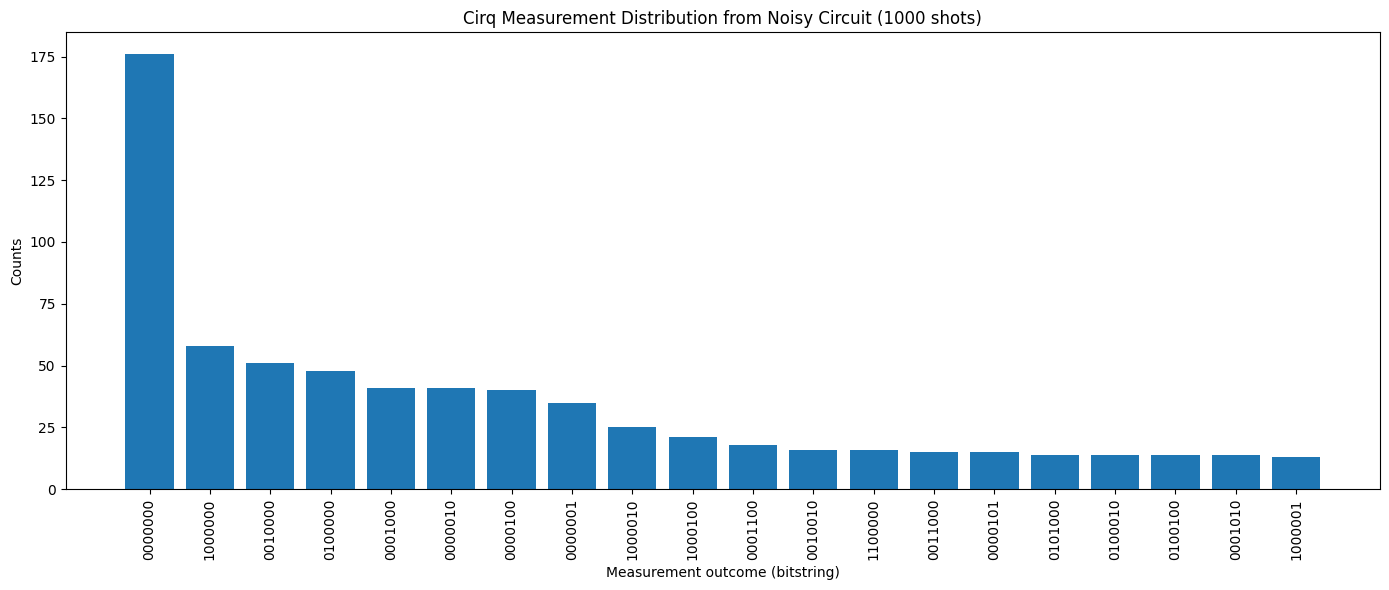


Total measurement outcomes captured: 1000


In [8]:
# Run the Cirq circuit with noise and generate samples
print("Running Cirq circuit with amplitude damping noise...")

# Create a simulator
cirq_simulator = qsimcirq.QSimSimulator()

# Run the circuit with a fixed number of repetitions
num_shots = 1000
cirq_results = cirq_simulator.run(cirq_circuit, repetitions=num_shots)

# Extract measurement results
measurements = cirq_results.measurements['result']
print(f"\nGenerated {len(measurements)} measurement samples")

# Convert to bitstrings and count occurrences
bitstrings = [''.join(map(str, measurement)) for measurement in measurements]
from collections import Counter
cirq_counts = Counter(bitstrings)

print(f"\nUnique measurement outcomes: {len(cirq_counts)}")
print("\nTop 10 measurement outcomes:")
for bitstring, count in cirq_counts.most_common(10):
    print(f"  {bitstring}: {count}")

# Plot the distribution
from matplotlib import pyplot as plt
top_outcomes = cirq_counts.most_common(20)
outcomes, counts_list = zip(*top_outcomes)

plt.figure(figsize=(14, 6))
plt.bar(range(len(outcomes)), counts_list)
plt.xlabel('Measurement outcome (bitstring)')
plt.ylabel('Counts')
plt.title(f'Cirq Measurement Distribution from Noisy Circuit ({num_shots} shots)')
plt.xticks(range(len(outcomes)), outcomes, rotation=90)
plt.tight_layout()
plt.show()

print(f"\nTotal measurement outcomes captured: {sum(cirq_counts.values())}")


In [11]:
qc_trajectree = Circuit()

qc_trajectree.qiskit_to_trajectree(transpiled_qc_custom, noise_parameter=noise_probability)

times_trajectree = qc_trajectree.perform_trajectree_simulation(num_simulations=100)

In [ ]:
from trajectree.quant_info.circuit import Circuit
import numpy as np

def run_experiment(max_cache_nodes=-1):
    num_simulations = 100 # 20

    num_qubits = 10

    cache_size = 1
    iter = 0
    max_iter = 1
    times = []

    while iter < max_iter:  # This while loop is just to perform the entire exoeriment multiple times to get average runtime values.
        # psi, t_eval = generate_test_circuit_trajectree(cache_size, max_cache_nodes)
        qc = Circuit(num_qubits)
        
        for i in range(num_qubits):
            qc.H_gate(i)

        # Damping layer
        for i in range(num_qubits):
            qc.amplitude_damping(0.1, i)

        qc.create_trajectree()

        times_iter = qc.perform_trajectree_simulation(num_simulations)

        times.append(times_iter)
        
        iter += 1
        print("iter:", iter)

    times_avg = np.mean(np.array(times).T, axis = 1)

    avg_times = [np.mean(times_avg[:i]) for i in range(1, len(times_avg))]

    return qc
    # return times
run_experiment()

iter: 1


In [5]:
num_qubits = 18
qubits = cirq.LineQubit.range(num_qubits)

noises = [cirq.amplitude_damp(gamma=0.1).on(qubits[i]) for i in range(num_qubits)]
gates = [cirq.H.on(qubits[i]) for i in range(num_qubits)]

circuit = cirq.Circuit(
    *gates,
    *noises,
    # cirq.H.on(qubits[5]),
    # *noises[6:],
    # *gates,
    # *noises
    # cirq.phase_damp(gamma=0.1).on(qubits[1]),
)
# measured_circuit = circuit + cirq.measure(*qubits, key='m')
print(circuit)

0: ────H───AD(0.1)───

1: ────H───AD(0.1)───

2: ────H───AD(0.1)───

3: ────H───AD(0.1)───

4: ────H───AD(0.1)───

5: ────H───AD(0.1)───

6: ────H───AD(0.1)───

7: ────H───AD(0.1)───

8: ────H───AD(0.1)───

9: ────H───AD(0.1)───

10: ───H───AD(0.1)───

11: ───H───AD(0.1)───

12: ───H───AD(0.1)───

13: ───H───AD(0.1)───

14: ───H───AD(0.1)───

15: ───H───AD(0.1)───

16: ───H───AD(0.1)───

17: ───H───AD(0.1)───


## Now, we implement the same circuit in Trajectree

In [ ]:
def run_experiment(max_cache_nodes=-1):
    num_simulations = 100 # 20

    num_qubits = 10

    cache_size = 1
    iter = 0
    max_iter = 1
    times = []

    while iter < max_iter:  # This while loop is just to perform the entire exoeriment multiple times to get average runtime values.
        # psi, t_eval = generate_test_circuit_trajectree(cache_size, max_cache_nodes)
        qc = Circuit(num_qubits)
        
        for i in range(num_qubits):
            qc.H_gate(i)

        # Damping layer
        for i in range(num_qubits):
            qc.amplitude_damping(0.1, i)

        qc.create_trajectree()

        times_iter = qc.perform_trajectree_simulation(num_simulations)

        times.append(times_iter)
        
        iter += 1
        print("iter:", iter)

    times_avg = np.mean(np.array(times).T, axis = 1)

    avg_times = [np.mean(times_avg[:i]) for i in range(1, len(times_avg))]

    return qc
    # return times
run_experiment()